In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import pandas as pd
import collections
from scipy.stats import beta, t
from numpy import random
%matplotlib inline


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
n = 500

In [ ]:
np.random.seed(100)
x = np.float32(np.linspace(0,10,n))
error =np.random.standard_normal(n)  # np.random.standard_t(2,n)
y = 0*np.cos(x)+error
y=np.float32(y)

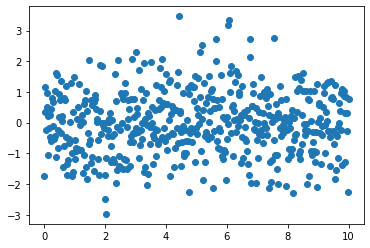

In [ ]:
plt.scatter(x,y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [ ]:
X = x.reshape(-1,1)
Y = y.reshape(-1,1)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
X = torch.FloatTensor(X).to(device)
Y = torch.FloatTensor(Y).to(device)
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.FloatTensor(y_train).to(device)
y_test = torch.FloatTensor(y_test).to(device)

In [ ]:
trainloader = DataLoader(X_train)
testloader = DataLoader(X_test)

In [ ]:
class Model(nn.Module):
  '''
  one could probably get decent performance (even without a second optimization step) by setting the hidden layer configuration using just two rules: 
  (i) number of hidden layers equals one; and 
  (ii) the number of neurons in that layer is the mean of the neurons in the input and output layers.
  '''
  def __init__(self, in_features=1, h1=10, h2=10, out_features=1):
    super().__init__()
    self.fc1 = nn.Linear(in_features,h1)    # input layer, in linear it already applied xavier initialization
    self.fc2 = nn.Linear(h1, h2)            # hidden layer
    self.out = nn.Linear(h2, out_features)  # output layer
        
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)
    return x

  def training_step(self, x, y):
    pass

  def validation_step(self, x, y):
    pass
  
  def validation_epoch_end(self, outputs):
    pass
  
  def epoch_end(self, epoch, result):
    pass

In [ ]:

class ModelTrainer():
  def fit(self, epochs=500, learning_rate=0.01, model=Model(),X_train=X_train,y_train=y_train,criterion = nn.MSELoss(), opt_func=torch.optim.Adam,seed=torch.manual_seed(4)):
    optimizer = opt_func(model.parameters(), learning_rate)

    for epoch in range(epochs):
        y_pred = model.forward(X_train)
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss

  def _evaluate(self, model, X_test, y_test,criterion = nn.MSELoss()):
    with torch.no_grad():
      y_val = model.forward(X_test)
      loss = criterion(y_val, y_test)
    return [loss,y_val]



In [ ]:
model = Model(h1=10,h2=20).to(device)
for param in model.parameters():
     print(param)

In [ ]:
best = []
for i in range(2,30):
  for j in range(2,30):
    model = Model(h1=i,h2=j).to(device)
    model_trainer = ModelTrainer()
    model_trainer.fit(500,0.01,model, X_train, y_train)
    best.append([i,j,model_trainer._evaluate(model,X_test,y_test)[0].to('cpu')])
  

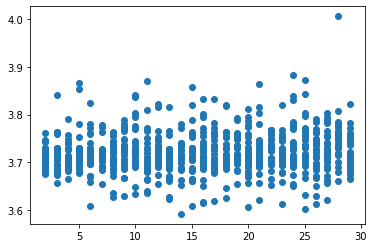

In [ ]:
plt.scatter(pd.DataFrame(best)[0],pd.DataFrame(best)[2],label='line1')

In [ ]:
pd.DataFrame(best)[(pd.DataFrame(best)[2]==min(pd.DataFrame(best)[2]))]

,0,1,2
349,14,15,tensor(3.5926)


In [ ]:
def find_MAD(r,data,i):
  c = abs(data['x']-data['x'][i])<r ##find the neighbour of x 
  mad = np.median(abs(data[c]['y']-data['y_hat'][i])) ## find MAD for those y's in the neighborhood of yhat belongs to x max|y1j-yhat1| j is the true y around yhat1 in x axis
  sigma = mad*1.5/np.sqrt(np.sum(c))
  return sigma

In [ ]:
  model = Model(h1=14,h2=15).to(device)
  model_trainer = ModelTrainer()
  model_trainer.fit(500,0.01,model, X_train, y_train)
  y_val = model_trainer._evaluate(model,X,Y)[1]

In [ ]:
cover=[]
for j in range(200):
  model = Model(h1=14,h2=15).to(device)
  model_trainer = ModelTrainer()
  model_trainer.fit(500,0.01,model, X_train, y_train,seed=j)
  y_val = model_trainer._evaluate(model,X,Y)[1]
  np.random.seed(j)
  x = np.float32(np.linspace(0,10,n))
  error = np.random.standard_normal(n) #np.random.standard_t(2,n)
  yori = np.multiply(x,0)
  y = np.multiply(x,0)+error
  y=np.float32(y)
  x0 = x.reshape(-1,1)
  x = x.reshape(-1,1)
  y0 = y.reshape(-1,1)
  y = y.reshape(-1,1)
  dat = np.concatenate([x,y],axis=1)
  x0 = torch.FloatTensor(x0).to(device)
  y0 = torch.FloatTensor(y0).to(device)
  a=y_val.cpu().detach().numpy().transpose()
  b=x0.cpu().detach().numpy().transpose()
  c=y0.cpu().detach().numpy().transpose()
  data = np.concatenate((b,c,a),axis=0).transpose()
  ###first col is x, second col is y, third col is y_hat
  data = pd.DataFrame(data)
  data = data.rename(columns={0: "x", 1: "y", 2:"y_hat"})
  sigma=[]
  for i in range(500):
    sigma.append(find_MAD(0.05,data,i))
  #upper = y_val+np.multiply(sigma,1.96)
  #lower = y_val-np.multiply(sigma,1.96)
  #coverage_rate.append(np.sum(np.logical_and(yori<upper[0], yori>lower[0]))/500)
  upper = a+np.multiply(sigma,1.96)
  lower = a-np.multiply(sigma,1.96)
  cover.append(np.logical_and(yori<upper[0], yori>lower[0]))

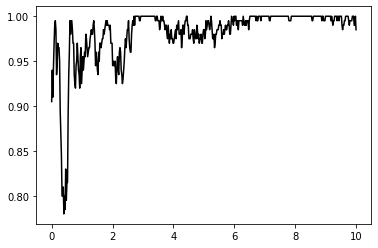

In [ ]:
type1 = pd.DataFrame(cover).sum(axis=0)/200
plt.plot(x0.to('cpu'),type1,'k-')

In [ ]:
from google.colab import files
type1.to_csv('type1.csv')
files.download('type1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

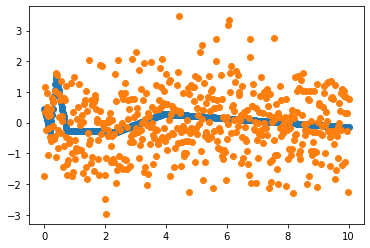

In [ ]:
plt.scatter(X.to('cpu'),y_val.to('cpu'),label='line1')
plt.scatter(X.to('cpu'),Y.to('cpu'),label='line2')


In [ ]:
yori

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
np.random.seed(100)
x = np.float32(np.linspace(0,10,n))
error =np.random.standard_normal(n)  # np.random.standard_t(2,n)
yori = np.multiply(x,0)
y = np.multiply(x,0)+error
y=np.float32(y)

In [ ]:
x0 = x.reshape(-1,1)
x = x.reshape(-1,1)
y0 = y.reshape(-1,1)
y = y.reshape(-1,1)
dat = np.concatenate([x,y],axis=1)
x0 = torch.FloatTensor(x0).to(device)
y0 = torch.FloatTensor(y0).to(device)

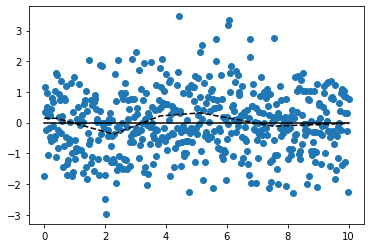

In [ ]:
plt.scatter(x0.to('cpu'),y0.to('cpu'))
plt.plot(x0.to('cpu'),yori,'k-')
plt.plot(x0.to('cpu'),y_val.to('cpu'),'k--')


In [ ]:
a=y_val.cpu().detach().numpy().transpose()
b=x0.cpu().detach().numpy().transpose()
c=y0.cpu().detach().numpy().transpose()

In [ ]:
data = np.concatenate((b,c,a),axis=0).transpose()
###first col is x, second col is y, third col is y_hat

In [ ]:
data = pd.DataFrame(data)

In [ ]:
data = data.rename(columns={0: "x", 1: "y", 2:"y_hat"})

In [ ]:
sigma=[]
for i in range(500):
  sigma.append(find_MAD(0.05,data,i))
#upper = y_val+np.multiply(sigma,1.96)
#lower = y_val-np.multiply(sigma,1.96)
#coverage_rate.append(np.sum(np.logical_and(yori<upper[0], yori>lower[0]))/500)

{'boxes': [<matplotlib.lines.Line2D at 0x7f16d1418950>],
 'caps': [<matplotlib.lines.Line2D at 0x7f16d1429450>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f16d142f490>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f16d1429f10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f16d1421990>,
  <matplotlib.lines.Line2D at 0x7f16d1421ed0>]}

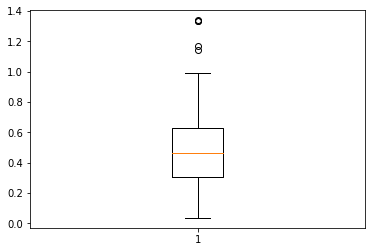

In [ ]:
plt.boxplot(sigma)

In [ ]:
upper = a+np.multiply(sigma,1.96)
lower = a-np.multiply(sigma,1.96)

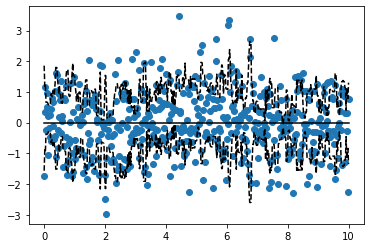

In [ ]:
plt.scatter(b,c)
plt.plot(b.reshape(500,1),yori,'k-')
plt.plot(b.reshape(500,1),upper.reshape(500,1),'k--')
plt.plot(b.reshape(500,1),lower.reshape(500,1),'k--')


In [ ]:
np.sum(np.logical_and(yori<upper[0], yori>lower[0]))

498

In [ ]:
window_size, coverage_rate = [], []
for j in range(1,100):
  sigma=[]
  for i in range(n):
    sigma.append(find_MAD(j/100,data,i))
  upper = a+np.multiply(sigma,1.96)
  lower = a-np.multiply(sigma,1.96)
  coverage_rate.append(np.sum(np.logical_and(yori<upper[0], yori>lower[0]))/n)
  window_size.append(j/100)

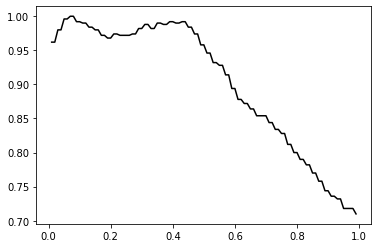

In [ ]:
plt.plot(window_size,coverage_rate,'k-')
#plt.ylim([0.8,1])

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving 9590_500caseTI.csv to 9590_500caseTI.csv
Saving 9595_500caseTI.csv to 9595_500caseTI.csv
Saving 9599_500caseTI.csv to 9599_500caseTI.csv


In [ ]:
cov9095 = pd.read_csv('9590_500caseTI.csv')  
cov9595 = pd.read_csv('9595_500caseTI.csv')
cov9995 = pd.read_csv('9599_500caseTI.csv')

Text(0.5, 1.0, 'Neural Network Performance')

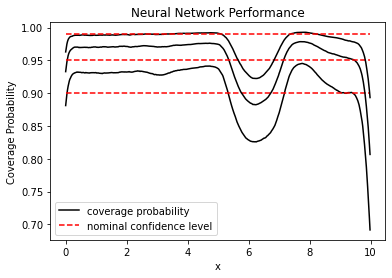

In [ ]:
plt.plot(cov9095.iloc[:,0]*0.02,cov9095.iloc[:,1],'k-',label='coverage probability')
plt.plot(cov9095.iloc[:,0]*0.02,[0.90]*500,'k--',color='red',label='nominal confidence level')
plt.plot(cov9595.iloc[:,0]*0.02,cov9595.iloc[:,1],'k-')
plt.plot(cov9095.iloc[:,0]*0.02,[0.95]*500,'k--',color='red')
plt.plot(cov9995.iloc[:,0]*0.02,cov9995.iloc[:,1],'k-')
plt.plot(cov9095.iloc[:,0]*0.02,[0.99]*500,'k--',color='red')
plt.legend()
plt.xlabel("x")
plt.ylabel("Coverage Probability")
plt.title('Neural Network Performance')